PROJECT TITLE:
Tourism Experience Analytics: Classification, Prediction, and Recommendation System

SUBMITTED BY: KIRTI (AIML Intern)

**Problem Statement:**

Tourism agencies and travel platforms aim to enhance user experiences by leveraging data to provide personalized recommendations, predict user satisfaction, and classify potential user behavior. This project involves analyzing user preferences, travel patterns, and attraction features to achieve three primary objectives: regression, classification, and recommendation.


Merge Everything ** ****Properly**

In [2]:
from google.colab import files
uploaded = files.upload()

Saving City.xlsx to City (4).xlsx
Saving Continent.xlsx to Continent (4).xlsx
Saving Country.xlsx to Country (4).xlsx
Saving Item.xlsx to Item (4).xlsx
Saving Mode.xlsx to Mode (4).xlsx
Saving Region.xlsx to Region (3).xlsx
Saving Transaction.xlsx to Transaction (3).xlsx
Saving Type.xlsx to Type (3).xlsx
Saving User.xlsx to User (3).xlsx


PHASE 1 — CLEAN & SAFE MERGING (FINAL VERSION)

In [3]:
!pip install openpyxl

import pandas as pd

# -------------------------
# LOAD ALL FILES
# -------------------------

transaction = pd.read_excel("Transaction.xlsx")
user = pd.read_excel("User.xlsx")
item = pd.read_excel("Item.xlsx")
atype = pd.read_excel("Type.xlsx")
mode = pd.read_excel("Mode.xlsx")
city = pd.read_excel("City.xlsx")
country = pd.read_excel("Country.xlsx")
region = pd.read_excel("Region.xlsx")
continent = pd.read_excel("Continent.xlsx")

# -------------------------
# RENAME TO AVOID _x _y CONFUSION
# -------------------------

user = user.rename(columns={
    "RegionId": "UserRegionId",
    "CountryId": "UserCountryId"
})

country = country.rename(columns={
    "RegionId": "CountryRegionId"
})

region = region.rename(columns={
    "ContinentId": "RegionContinentId"
})

city = city.rename(columns={
    "CityId": "AttractionCityId",
    "CityName": "AttractionCityName"
})

mode = mode.rename(columns={
    "VisitModeId": "VisitModeKey"
})

# -------------------------
# MERGING (CORRECT ORDER)
# -------------------------

# Transaction + User
merged = transaction.merge(user, on="UserId", how="left")

# Merge Country (based on user's country)
merged = merged.merge(country, left_on="UserCountryId", right_on="CountryId", how="left")

# Merge Region (based on country region)
merged = merged.merge(region, left_on="CountryRegionId", right_on="RegionId", how="left")

# Merge Continent
merged = merged.merge(continent, left_on="RegionContinentId", right_on="ContinentId", how="left")

# Merge Attraction Info
merged = merged.merge(item, on="AttractionId", how="left")

# Merge Attraction Type
merged = merged.merge(atype, on="AttractionTypeId", how="left")

# Merge Visit Mode
merged = merged.merge(mode, left_on="VisitMode", right_on="VisitModeKey", how="left")

# Merge Attraction City
merged = merged.merge(city, on="AttractionCityId", how="left")

# -------------------------
# SAVE FINAL DATASET
# -------------------------

merged.to_csv("merged_tourism_dataset.csv", index=False)

print("Final merged dataset shape:", merged.shape)
print("Columns:", merged.columns)

Final merged dataset shape: (52930, 28)
Columns: Index(['TransactionId', 'UserId', 'VisitYear', 'VisitMonth', 'VisitMode_x',
       'AttractionId', 'Rating', 'ContinentId_x', 'UserRegionId',
       'UserCountryId', 'CityId', 'CountryId_x', 'Country', 'CountryRegionId',
       'Region', 'RegionId', 'RegionContinentId', 'ContinentId_y', 'Continent',
       'AttractionCityId', 'AttractionTypeId', 'Attraction',
       'AttractionAddress', 'AttractionType', 'VisitModeKey', 'VisitMode_y',
       'AttractionCityName', 'CountryId_y'],
      dtype='object')


PHASE 2 — EDA (Correct Structure)

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("merged_tourism_dataset.csv")

print(df.shape)
print(df.info())
print(df.isnull().sum())

(52930, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52930 entries, 0 to 52929
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TransactionId       52930 non-null  int64  
 1   UserId              52930 non-null  int64  
 2   VisitYear           52930 non-null  int64  
 3   VisitMonth          52930 non-null  int64  
 4   VisitMode_x         52930 non-null  int64  
 5   AttractionId        52930 non-null  int64  
 6   Rating              52930 non-null  int64  
 7   ContinentId_x       52930 non-null  int64  
 8   UserRegionId        52930 non-null  int64  
 9   UserCountryId       52930 non-null  int64  
 10  CityId              52922 non-null  float64
 11  CountryId_x         52930 non-null  int64  
 12  Country             52930 non-null  object 
 13  CountryRegionId     52930 non-null  int64  
 14  Region              52930 non-null  object 
 15  RegionId            52930 non-null  int64

In [5]:
# Reduce memory usage automatically
def reduce_memory(df):
    for col in df.columns:
        col_type = df[col].dtype

        if col_type == "int64":
            df[col] = pd.to_numeric(df[col], downcast="integer")

        elif col_type == "float64":
            df[col] = pd.to_numeric(df[col], downcast="float")

        elif col_type == "object":
            df[col] = df[col].astype("category")

    return df

df = reduce_memory(df)

print("Memory usage after optimization:")
print(df.memory_usage(deep=True).sum() / 1024**2, "MB")

Memory usage after optimization:
2.142568588256836 MB


Rating Distribution

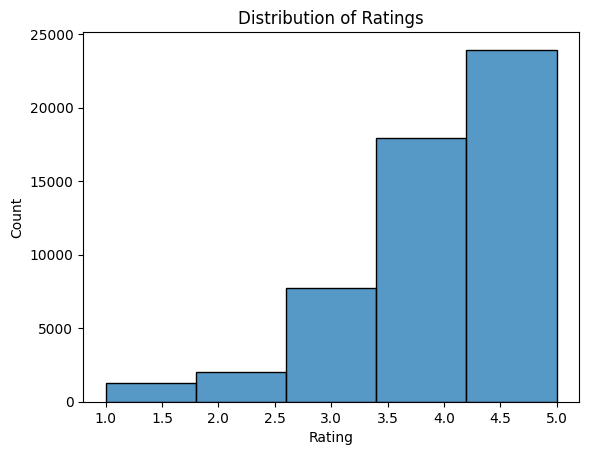

In [6]:
sns.histplot(df["Rating"], bins=5)
plt.title("Distribution of Ratings")
plt.show()

Ratings by Attraction Type

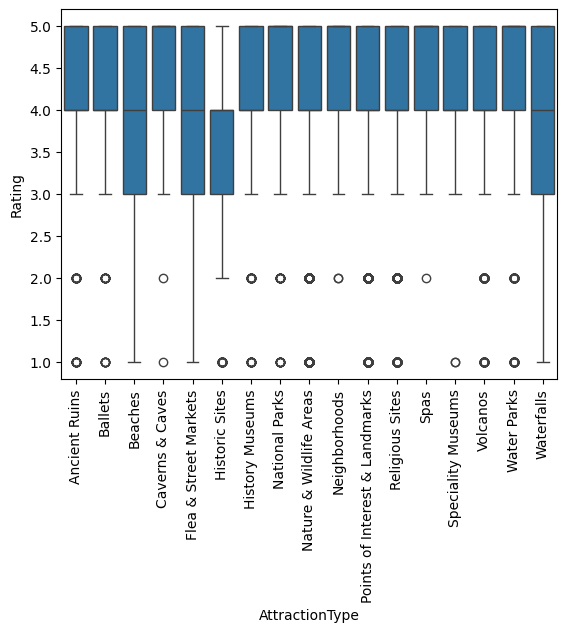

In [7]:
sns.boxplot(x="AttractionType", y="Rating", data=df)
plt.xticks(rotation=90)
plt.show()

PHASE 3 — FEATURE ENGINEERING (CLEAN VERSION)

1) season Faeture

In [8]:
# Convert to numeric safely
df["VisitMonth"] = pd.to_numeric(df["VisitMonth"], errors="coerce")

# Vectorised mapping (much faster, low RAM)
season_map = {
    12: "Winter", 1: "Winter", 2: "Winter",
    3: "Spring", 4: "Spring", 5: "Spring",
    6: "Summer", 7: "Summer", 8: "Summer",
    9: "Fall", 10: "Fall", 11: "Fall"
}

df["Season"] = df["VisitMonth"].map(season_map)

Rating Distribution

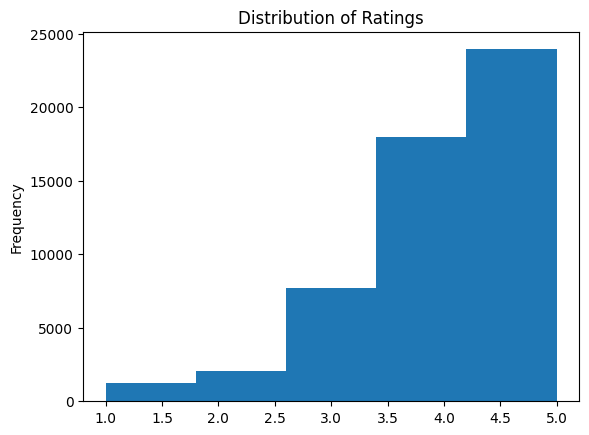

In [9]:
import matplotlib.pyplot as plt

df["Rating"].plot(kind="hist", bins=5)
plt.title("Distribution of Ratings")
plt.show()

Average Rating by Season

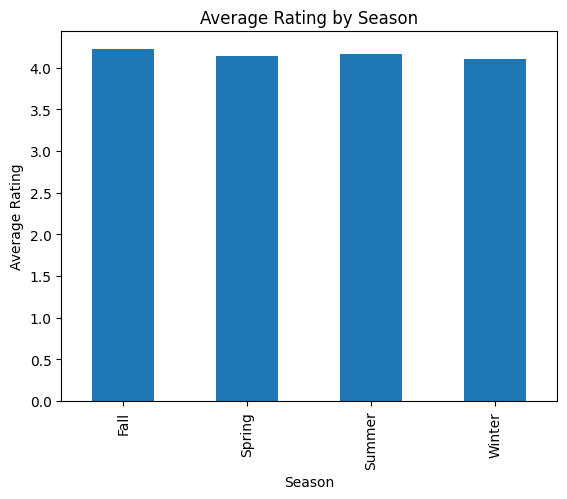

In [10]:
season_avg = df.groupby("Season")["Rating"].mean()

season_avg.plot(kind="bar")
plt.title("Average Rating by Season")
plt.ylabel("Average Rating")
plt.show()

Year-wise Trend

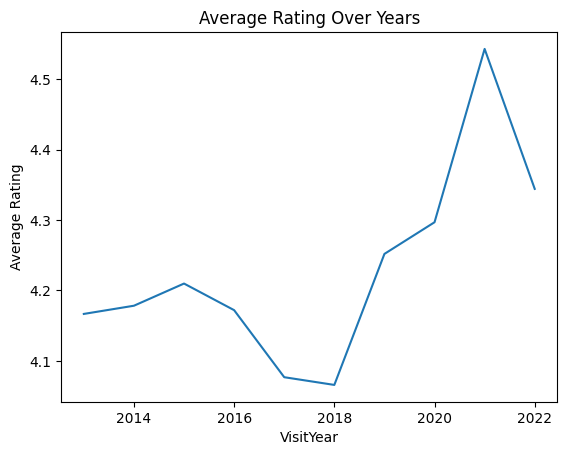

In [11]:
year_avg = df.groupby("VisitYear")["Rating"].mean()

year_avg.plot()
plt.title("Average Rating Over Years")
plt.ylabel("Average Rating")
plt.show()

Top 10 Most Visited Attractions

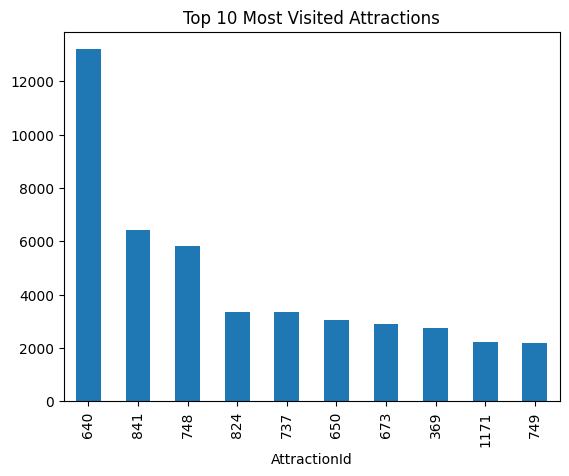

In [12]:
top_attr = df["AttractionId"].value_counts().head(10)

top_attr.plot(kind="bar")
plt.title("Top 10 Most Visited Attractions")
plt.show()

Visit Mode Distribution

In [14]:
user_avg = df.groupby("UserId")["Rating"].mean().reset_index()
user_avg.columns = ["UserId", "UserAvgRating"]

df = df.merge(user_avg, on="UserId", how="left")

3) Attraction Popularity

In [15]:
attraction_pop = df.groupby("AttractionId").size().reset_index(name="VisitCount")

df = df.merge(attraction_pop, on="AttractionId", how="left")

4) Local Travel Feature

In [16]:
df["IsLocalTravel"] = (df["CityId"] == df["AttractionCityId"]).astype(int)

PHASE 4 — REGRESSION MODEL (PROPER PIPELINE)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

regression_df = df.copy()

# Drop unwanted IDs
regression_df = regression_df.drop(columns=["TransactionId"], errors="ignore")

# Handle missing
regression_df.fillna(method="ffill", inplace=True)

# One-hot encode ONCE
regression_df = pd.get_dummies(regression_df, drop_first=True)

X = regression_df.drop("Rating", axis=1)
y = regression_df["Rating"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model_reg = RandomForestRegressor(random_state=42)
model_reg.fit(X_train, y_train)

y_pred = model_reg.predict(X_test)

print("R²:", round(r2_score(y_test, y_pred), 4))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 4))

/tmp/ipython-input-801599899.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  regression_df.fillna(method="ffill", inplace=True)


R²: 0.6829
RMSE: 0.5465


PHASE 5 — CLASSIFICATION (FIXED)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

classification_df = df.copy()

# ✅ Fix deprecated warning
classification_df.ffill(inplace=True)

# ----------------------------
# Automatically find VisitMode column
# ----------------------------

visit_mode_cols = [col for col in classification_df.columns if "VisitMode" in col]

print("Visit mode related columns:", visit_mode_cols)

if len(visit_mode_cols) == 0:
    raise ValueError("No VisitMode column found.")

# Choose correct target column
# Usually the descriptive one (string), not ID
target_col = visit_mode_cols[0]

print("Using target column:", target_col)

# ----------------------------
# Encode target
# ----------------------------

le = LabelEncoder()
classification_df["VisitModeEncoded"] = le.fit_transform(classification_df[target_col])

# ----------------------------
# Prepare features
# ----------------------------

X_clf = classification_df.drop(columns=[target_col, "VisitModeEncoded", "Rating"], errors="ignore")
y_clf = classification_df["VisitModeEncoded"]

# One-hot encode features
X_clf = pd.get_dummies(X_clf, drop_first=True)

# Split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42
)

# Train
model_clf = RandomForestClassifier(random_state=42)
model_clf.fit(X_train_clf, y_train_clf)

print("Classification model trained successfully!")

Visit mode related columns: ['VisitMode_x', 'VisitModeKey', 'VisitMode_y']
Using target column: VisitMode_x
Classification model trained successfully!


PHASE 6 — RECOMMENDATION SYSTEM (PROPER VERSION)

Step 1: Create User-Item Matrix

In [19]:
recommendation_df = df[["UserId", "AttractionId", "Rating"]]

user_item = recommendation_df.pivot_table(
    index="UserId",
    columns="AttractionId",
    values="Rating"
).fillna(0)

Step 2: Cosine Similarity

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(user_item)

PHASE 7 — SAVE MODELS

In [ ]:
import pickle

# Save regression
pickle.dump(model_reg, open("regression_model.pkl", "wb"))

# Save classification
pickle.dump(model_clf, open("classification_model.pkl", "wb"))

# Save recommendation components
pickle.dump(similarity, open("similarity_matrix.pkl", "wb"))
pickle.dump(user_item, open("user_item_matrix.pkl", "wb"))

print("All models saved successfully!")